In [88]:
import rpy2.robjects as robjects
import numpy as np

robjects.r['load']("../data/metzner07_example1_sim.Rdata")
C=np.array(robjects.r['C'])
C=np.transpose(np.array(C))
for i in range(0, 2):
    C[i] = np.transpose(C[i])
    
step_sizes = np.array([0.01, 0.1, 1])

In [89]:
from pymc3 import Continuous
from pymc3.distributions import transforms
import theano.tensor as T
from theano.tensor.nlinalg import eig, matrix_inverse

#prior
class DiscreteObsMJP_unif_prior(Continuous):

    def __init__(self, n, transform=transforms.log, *args, **kwargs):
        super(DiscreteObsMJP_unif_prior, self).__init__(transform=transform, *args, **kwargs)
        Q_raw = np.ones((n,n-1))
        self.n = n
        self.mode = Q_raw

    def logp(self, value):
        return 0

#likelihood
class DiscreteObsMJP(Continuous):

    def __init__(self, Q_raw, step_sizes, *args, **kwargs):
        super(DiscreteObsMJP, self).__init__(*args, **kwargs)
        self.Q_raw = Q_raw
        self.step_sizes = step_sizes

    #@as_op(itypes=[T.dmatrix], otypes=[T.cmatrix])
    def convertFromRaw(self, Q_raw):

        #get integer value and symbolic representation
        nrows, ncols = Q_raw.transformed.dshape
        nrows_s, ncols_s = Q_raw.shape 

        #create Q
        Q = T.alloc(0.0, *(nrows_s, ncols_s+1))
        Q.name = 'Q'

        #fill Q
        row_sums = Q_raw.sum(axis=1)
        for i in range(0, nrows):
            ind = 0
            for j in range(0, ncols+1):
                if i==j:
                    Q = T.set_subtensor(Q[i,j], -row_sums[i])
                else:
                    Q = T.set_subtensor(Q[i,j], Q_raw[i,ind])
                    ind += 1
                    
        return Q
        
    def logp(self, C):
        Q_raw = self.Q_raw
        step_sizes = self.step_sizes

        Q = self.convertFromRaw(Q_raw)
        Q_complex = T.cast(Q, 'complex64')

        l = 0.0
        for i in range(0, len(step_sizes)):
            #get P(tau)
            lambdas, U = eig(Q_complex)
            
            tau = step_sizes[i]
            exp_tD = T.diag(T.exp(tau*lambdas))

            U_inv = matrix_inverse(U)

            P = U.dot(exp_tD).dot(U_inv)
        
            #compute likelihood in terms of P(tau)
            l += T.sum(C[i]*T.log(P))
            
        return l

In [90]:
start = {'Q_raw': np.array([[2, 2, 1, 1], 
   [1, 0, 1, 2],
   [1, 0, 2, 1],
   [2, 1, 0, 0],
   [1, 1, 1, 1]])}

In [97]:
with Model() as model:

    Q_raw = DiscreteObsMJP_unif_prior('Q_raw', n=5, shape=(5,4))
    #pymc3.Continuous('D_obs', 
    D_obs = DiscreteObsMJP('D_obs', Q_raw=Q_raw, step_sizes=step_sizes, observed=C)

    step = Metropolis()
    trace = sample(100000, step, start=start)

 [-----------------100%-----------------] 100000 of 100000 complete in 168.5 sec

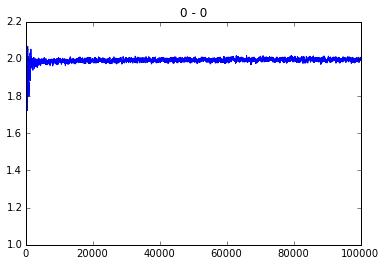

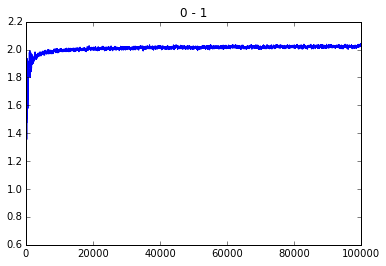

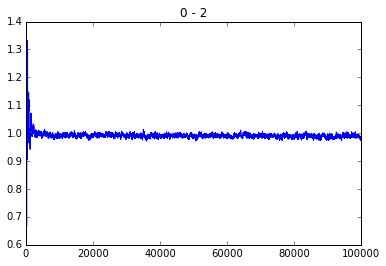

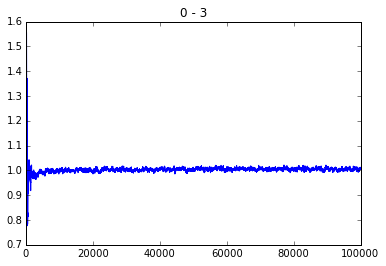

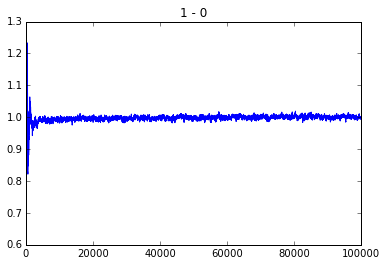

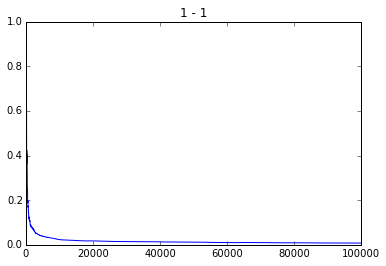

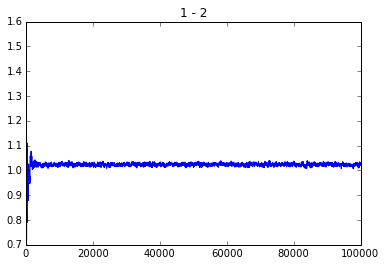

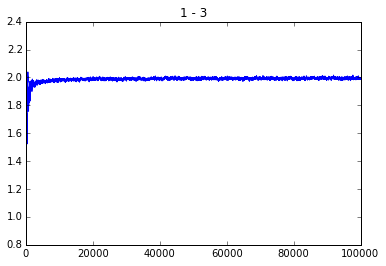

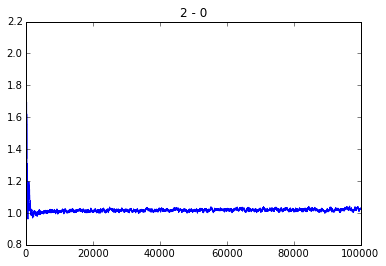

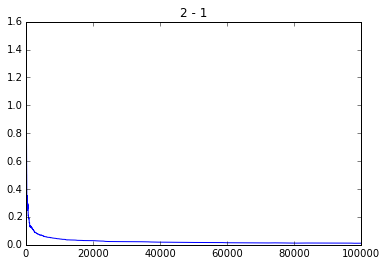

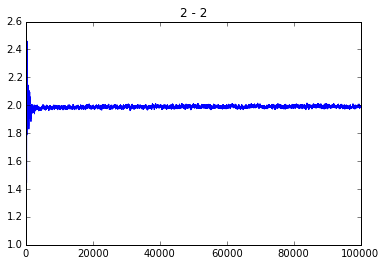

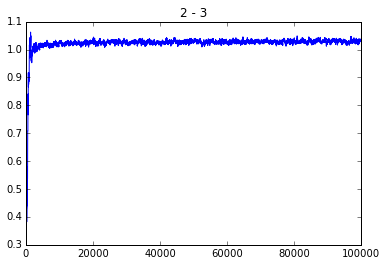

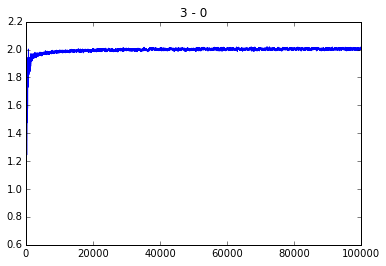

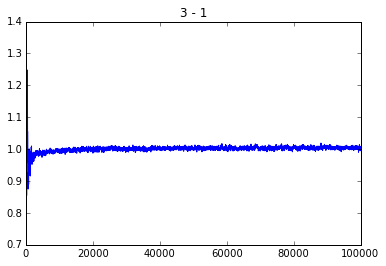

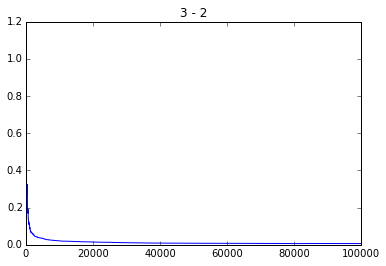

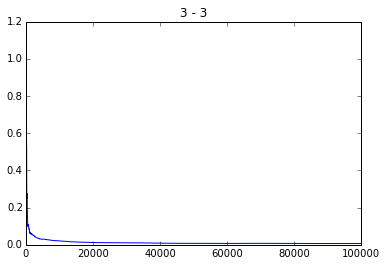

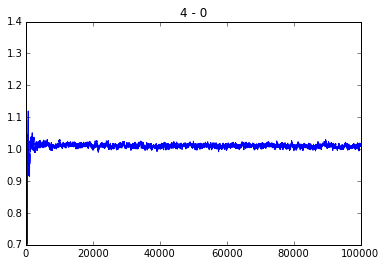

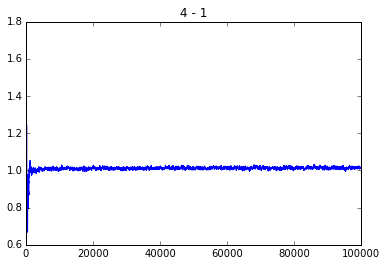

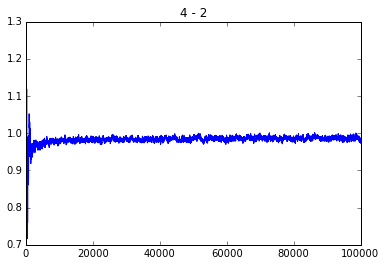

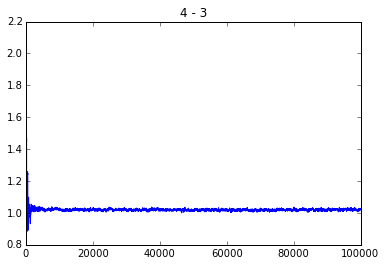

In [98]:
%matplotlib inline
import matplotlib.pyplot as plt
import itertools

traceQ = trace[Q_raw]
for i,j in itertools.product(range(5), range(4)):
    plt.figure()
    plt.plot(traceQ[:,i,j])
    plt.title('%i - %i' %(i,j))

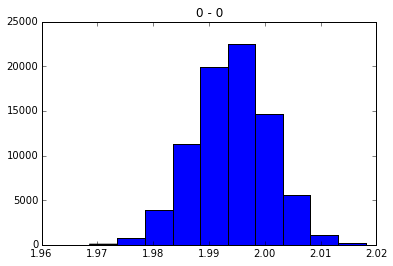

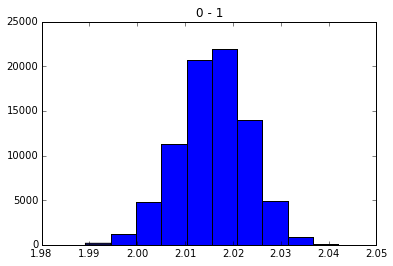

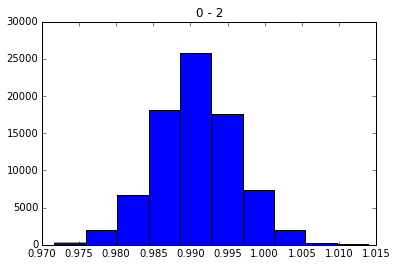

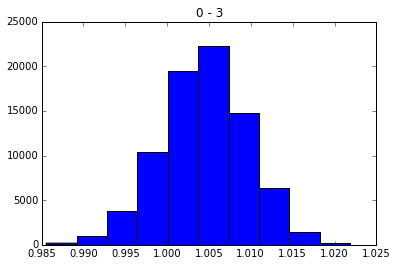

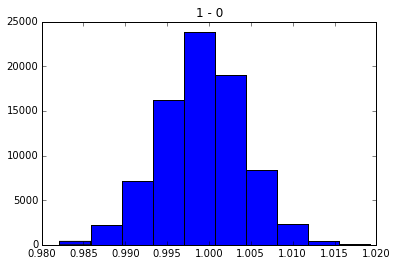

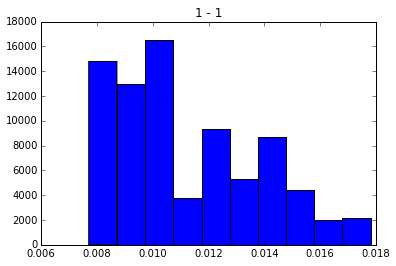

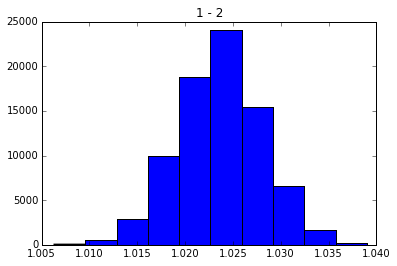

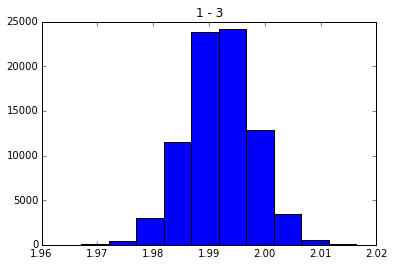

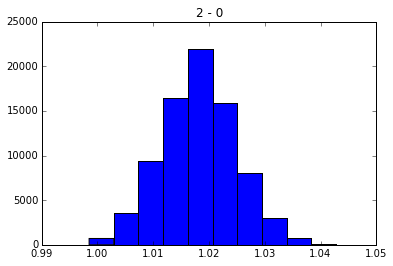

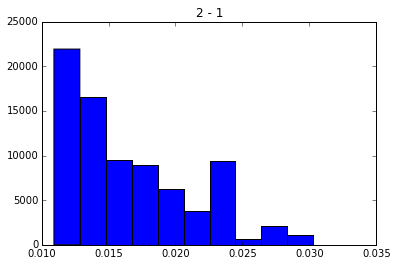

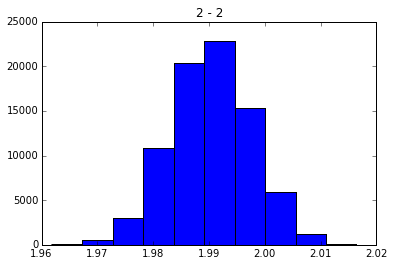

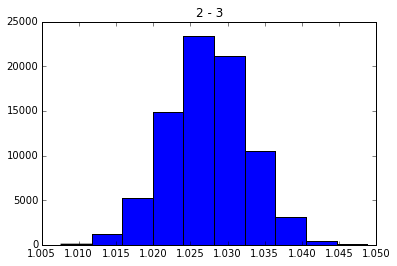

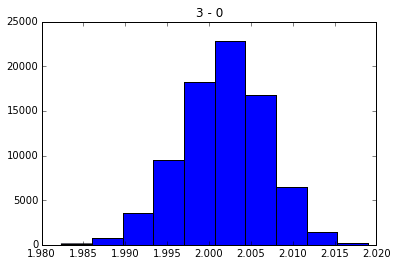

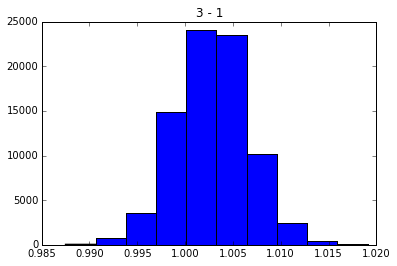

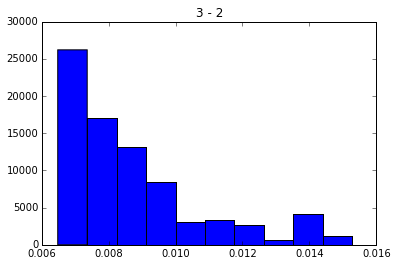

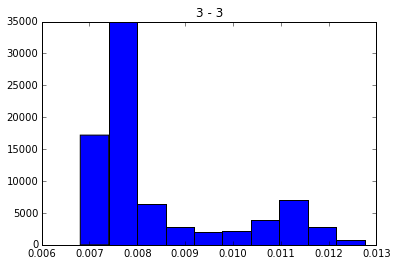

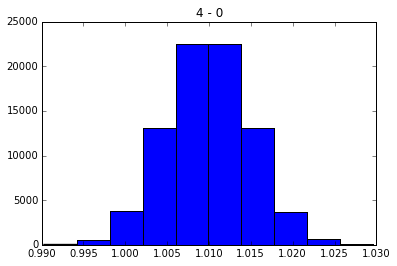

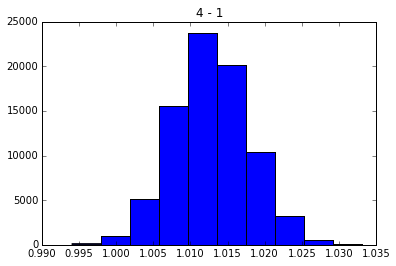

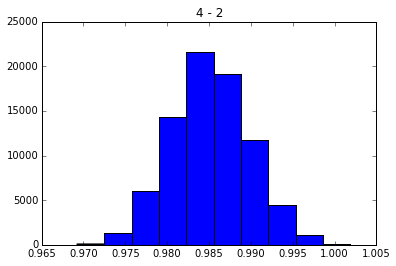

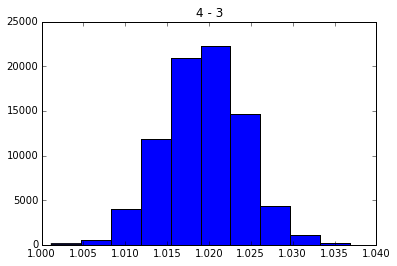

In [100]:
for i,j in itertools.product(range(5), range(4)):
    plt.figure()
    plt.hist(traceQ[20000:999999,i,j])
    plt.title('%i - %i' %(i,j))

In [95]:
traceQ[9999,:,:]

array([[ 1.98723423,  1.97886059,  0.99680148,  0.99270625],
       [ 0.99744543,  0.02598948,  1.0192691 ,  1.98167001],
       [ 1.0042481 ,  0.03898991,  1.98239726,  1.02559574],
       [ 1.98076677,  0.99387549,  0.02182062,  0.02009736],
       [ 1.00620036,  1.01879005,  0.97962995,  1.0114184 ]])

Q_raw